In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [2]:
#cecum = 1, else = 0
label_path = 'Data/라벨링데이터/'
img_path = 'Data/원천데이터/'

In [7]:
path = 'Data/원천데이터/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  1897
Image_labels: 1897


In [8]:
img_names

['Data/원천데이터/KI_기아/028_K7/2017_검정_트림B/C_210812_KI_028_17_BK_B_T_03_018.jpg',
 'Data/원천데이터/KI_기아/028_K7/2017_검정_트림B/C_210812_KI_028_17_BK_B_P_01_029.jpg',
 'Data/원천데이터/KI_기아/028_K7/2017_검정_트림B/C_210812_KI_028_17_BK_B_P_01_069.jpg',
 'Data/원천데이터/KI_기아/028_K7/2017_검정_트림A/C_210812_KI_028_17_BK_A_T_02_004.jpg',
 'Data/원천데이터/KI_기아/028_K7/2017_검정_트림A/C_211203_KI_028_17_BK_A_T_02_010.jpg',
 'Data/원천데이터/KI_기아/028_K7/2017_검정_트림A/C_211203_KI_028_17_BK_A_P_01_012.jpg',
 'Data/원천데이터/KI_기아/028_K7/2017_검정_트림A/C_211203_KI_028_17_BK_A_P_01_036.jpg',
 'Data/원천데이터/KI_기아/028_K7/2017_검정_트림A/C_210812_KI_028_17_BK_A_P_01_007.jpg',
 'Data/원천데이터/KI_기아/028_K7/2017_검정_트림A/C_210812_KI_028_17_BK_A_T_03_012.jpg',
 'Data/원천데이터/KI_기아/028_K7/2020_흰색_트림C/C_210820_KI_028_20_WH_C_P_01_063.jpg',
 'Data/원천데이터/KI_기아/028_K7/2020_흰색_트림C/C_210820_KI_028_20_WH_C_T_03_011.jpg',
 'Data/원천데이터/KI_기아/028_K7/2020_흰색_트림C/C_210820_KI_028_20_WH_C_T_03_016.jpg',
 'Data/원천데이터/KI_기아/028_K7/2020_흰색_트림C/C_210820_KI_028_20_WH_C_T_02_008.jpg',

In [9]:
img_labels

['KI_028_17',
 'KI_028_17',
 'KI_028_17',
 'KI_028_17',
 'KI_028_17',
 'KI_028_17',
 'KI_028_17',
 'KI_028_17',
 'KI_028_17',
 'KI_028_20',
 'KI_028_20',
 'KI_028_20',
 'KI_028_20',
 'KI_028_20',
 'KI_028_20',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_20',
 'KI_028_20',
 'KI_028_20',
 'KI_028_20',
 'KI_028_20',
 'KI_028_20',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_18',
 'KI_028_21',
 'KI_028_21',
 'KI_028_21',
 'KI_028_21',
 'KI_028_21',
 'KI_028_21',
 'KI_028_21',
 'KI_028_21',
 'KI_028_21',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_19',
 'KI_028_17',
 'KI_028_17',
 'KI_028_17',
 'KI_028_17',
 'KI_028_17',
 'KI_0

In [15]:
random.shuffle(true_dir)
random.shuffle(false_dir)

In [8]:
true_label = [1]*int(len(true_dir))

In [10]:
false_label = [0]*int(len(false_dir))

In [11]:
print(false_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
whole_dir = true_dir + false_dir

In [14]:
whole_label = true_label + false_label

In [15]:
print(len(whole_dir))

12524


In [16]:
print(len(whole_label))

12524


In [24]:
sample_train =[]
sample_label1 =[]
sample_label2 =[]

t1 = 'BM_004_18'
t2 = 'BE_009_17'

for i in range(len(img_names)):
    if t1 in img_names[i]:
        sample_train.append(img_names[i])
        sample_label1.append(img_labels[i])
    if t2 in img_names[i]:
        sample_train.append(img_names[i])
        sample_label2.append(img_labels[i])
    

In [27]:
sample_label1 = [0]*int(len(sample_label1))
sample_label2 = [1]*int(len(sample_label2))

In [28]:
sample_label = sample_label1 + sample_label2

In [29]:
trn_df = pd.DataFrame(sample_train, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = sample_label
train = trn_df
train

,image_id,dir,label
0,C_211206_BE_009_17_WH_B_T_02_002.jpg,Data/원천데이터/BE_벤츠/009_C-Class/2017_흰색_트림B,0
1,C_211206_BE_009_17_WH_B_P_01_049.jpg,Data/원천데이터/BE_벤츠/009_C-Class/2017_흰색_트림B,0
2,C_211222_BE_009_17_WH_B_T_02_006.jpg,Data/원천데이터/BE_벤츠/009_C-Class/2017_흰색_트림B,0
3,C_211201_BE_009_17_WH_B_P_01_053.jpg,Data/원천데이터/BE_벤츠/009_C-Class/2017_흰색_트림B,0
4,C_211201_BE_009_17_WH_B_P_01_047.jpg,Data/원천데이터/BE_벤츠/009_C-Class/2017_흰색_트림B,0
...,...,...,...
115,C_211210_BM_004_18_GR_A_T_03_010.jpg,Data/원천데이터/BM_BMW/004_5시리즈/2018_회색_트림A,1
116,C_211011_BM_004_18_GR_A_P_01_022.jpg,Data/원천데이터/BM_BMW/004_5시리즈/2018_회색_트림A,1
117,C_211011_BM_004_18_GR_A_T_02_005.jpg,Data/원천데이터/BM_BMW/004_5시리즈/2018_회색_트림A,1
118,C_211210_BM_004_18_GR_A_T_03_002.jpg,Data/원천데이터/BM_BMW/004_5시리즈/2018_회색_트림A,1


In [30]:
train.label.value_counts()

0    69
1    51
Name: label, dtype: int64

In [31]:
project_name = 'test_car_classification'
user = 'hojunking'
run_name = 'test_car_classification_efficientnet_lite0_size192'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Training start with epoch 50 



/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.7744: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


train accuracy = 0.48182
[[37 18]
 [39 16]]


epoch 0 loss: 0.7185: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


validation accuracy = 0.45833
[[7 7]
 [6 4]]


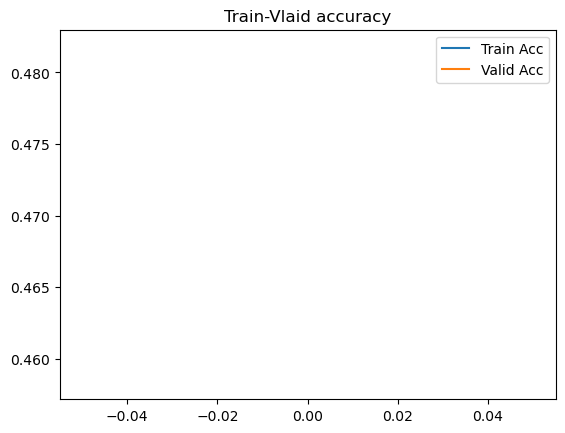

epoch 1 loss: 0.6720: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


train accuracy = 0.50000
[[31 24]
 [31 24]]


epoch 1 loss: 0.7150: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


validation accuracy = 0.45833
[[6 8]
 [5 5]]


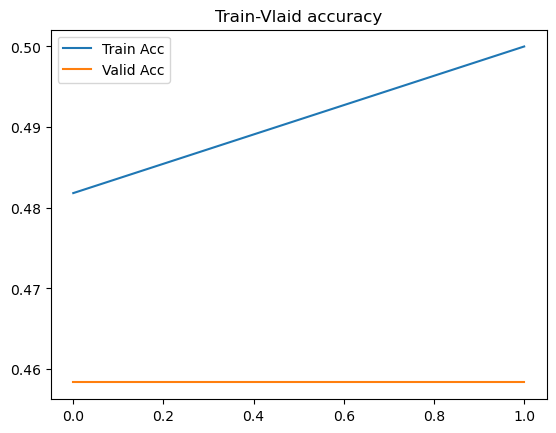

epoch 2 loss: 0.6486: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


train accuracy = 0.69091
[[37 18]
 [16 39]]


epoch 2 loss: 0.7250: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


validation accuracy = 0.45833
[[6 8]
 [5 5]]


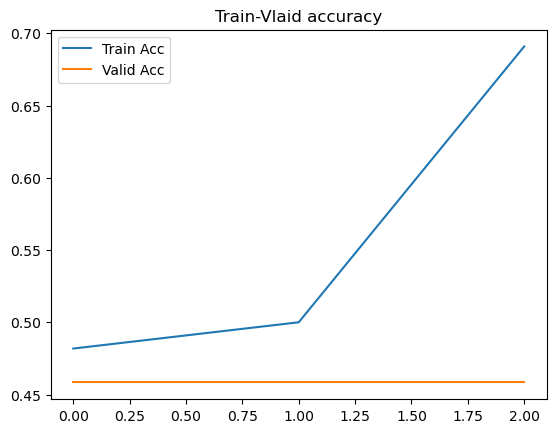

epoch 3 loss: 0.6225: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


train accuracy = 0.72727
[[41 14]
 [16 39]]


epoch 3 loss: 0.7328: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


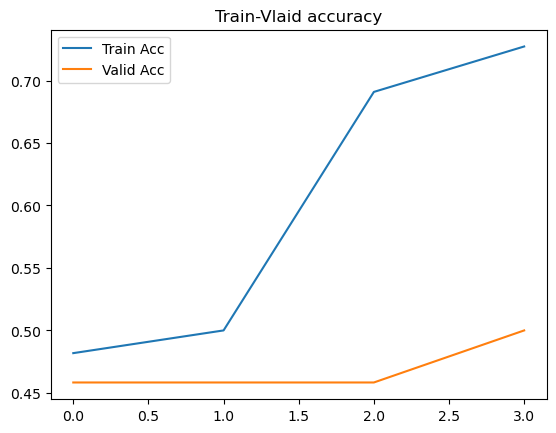

epoch 4 loss: 0.5829: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


train accuracy = 0.78182
[[43 12]
 [12 43]]


epoch 4 loss: 0.7266: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


validation accuracy = 0.54167
[[8 6]
 [5 5]]


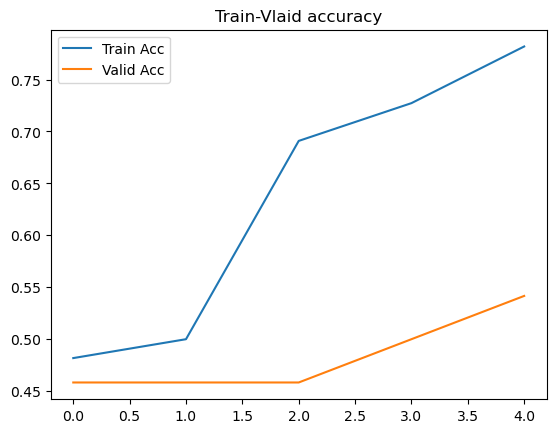

epoch 5 loss: 0.6181: 100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


train accuracy = 0.84545
[[46  9]
 [ 8 47]]


epoch 5 loss: 0.7293: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


validation accuracy = 0.54167
[[8 6]
 [5 5]]


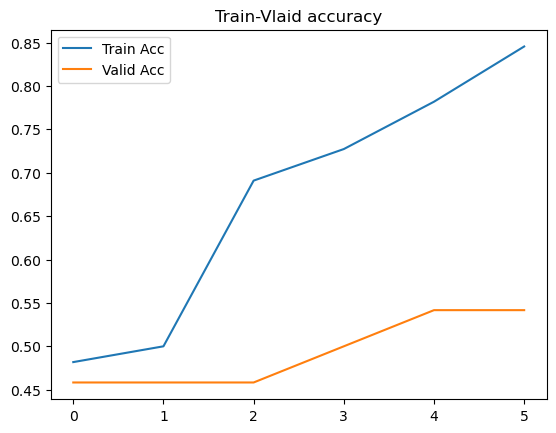

epoch 6 loss: 0.5659: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


train accuracy = 0.80909
[[45 10]
 [11 44]]


epoch 6 loss: 0.7365: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


validation accuracy = 0.58333
[[9 5]
 [5 5]]


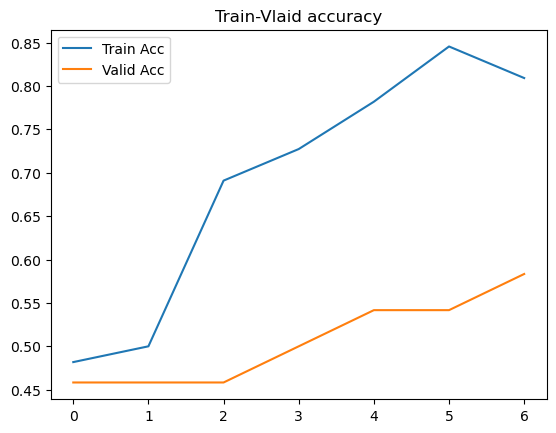

epoch 7 loss: 0.4958: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]


train accuracy = 0.84545
[[47  8]
 [ 9 46]]


epoch 7 loss: 0.7507: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


validation accuracy = 0.54167
[[9 5]
 [6 4]]


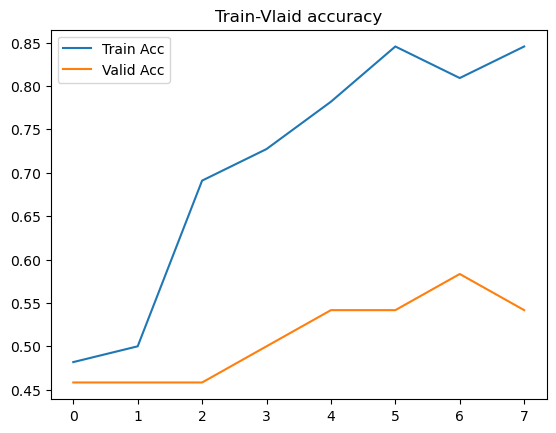

epoch 8 loss: 0.4770: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


train accuracy = 0.85455
[[50  5]
 [11 44]]


epoch 8 loss: 0.7602: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


validation accuracy = 0.58333
[[9 5]
 [5 5]]


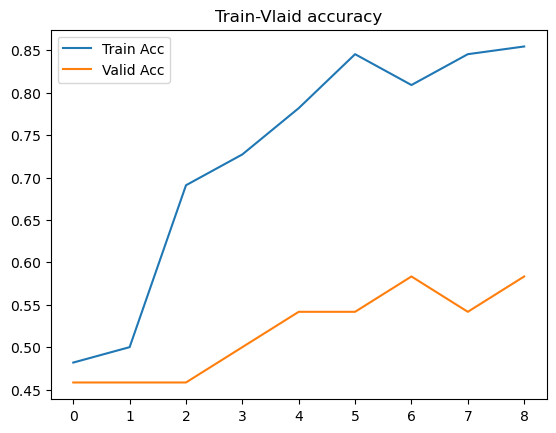

epoch 9 loss: 0.5409: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


train accuracy = 0.84545
[[48  7]
 [10 45]]


epoch 9 loss: 0.7610: 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


validation accuracy = 0.58333
[[9 5]
 [5 5]]


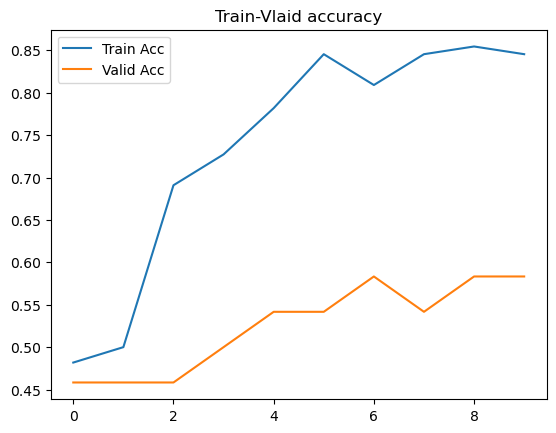

epoch 10 loss: 0.5078: 100%|██████████| 11/11 [00:04<00:00,  2.30it/s]


train accuracy = 0.87273
[[47  8]
 [ 6 49]]


epoch 10 loss: 0.7620: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


validation accuracy = 0.62500
[[9 5]
 [4 6]]


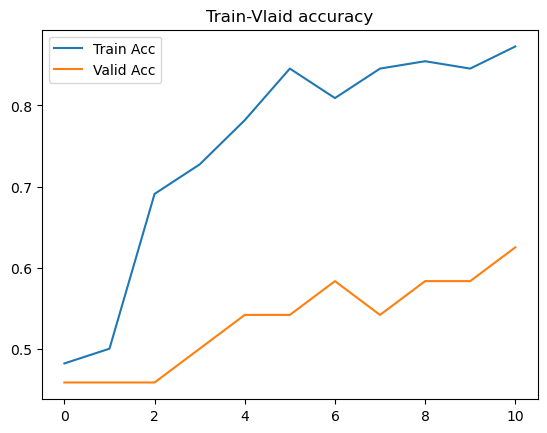

epoch 11 loss: 0.4985: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


train accuracy = 0.86364
[[49  6]
 [ 9 46]]


epoch 11 loss: 0.7797: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


validation accuracy = 0.58333
[[7 7]
 [3 7]]


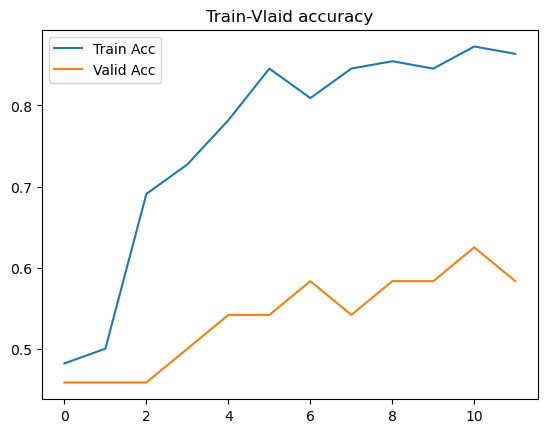

epoch 12 loss: 0.3161: 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]


train accuracy = 0.87273
[[48  7]
 [ 7 48]]


epoch 12 loss: 0.7858: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


validation accuracy = 0.62500
[[8 6]
 [3 7]]


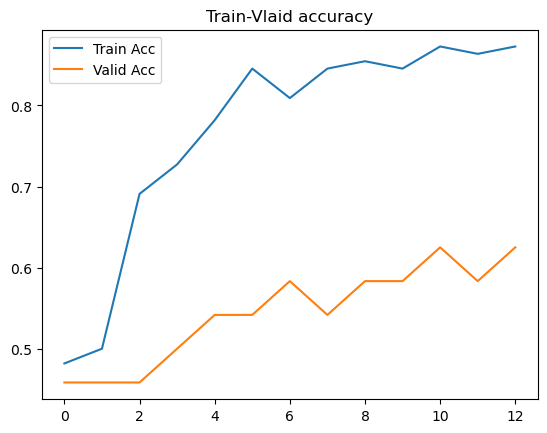

epoch 13 loss: 0.4572: 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]


train accuracy = 0.88182
[[47  8]
 [ 5 50]]


epoch 13 loss: 0.8316: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


validation accuracy = 0.50000
[[8 6]
 [6 4]]


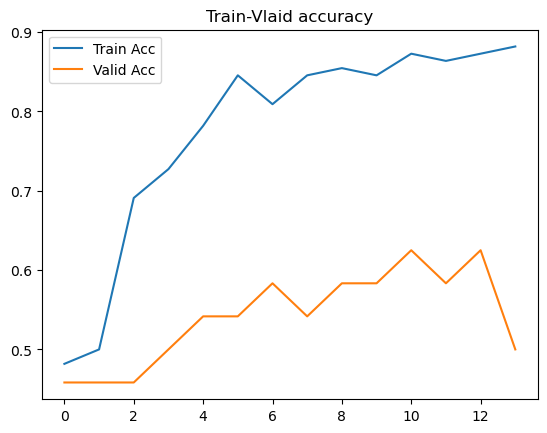

epoch 14 loss: 0.3705: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


train accuracy = 0.92727
[[50  5]
 [ 3 52]]


epoch 14 loss: 0.7977: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


validation accuracy = 0.54167
[[8 6]
 [5 5]]


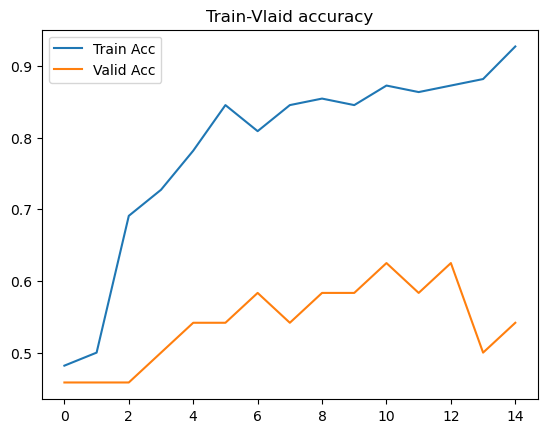

epoch 15 loss: 0.2821: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]


train accuracy = 0.90909
[[47  8]
 [ 2 53]]


epoch 15 loss: 0.8072: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


validation accuracy = 0.54167
[[8 6]
 [5 5]]


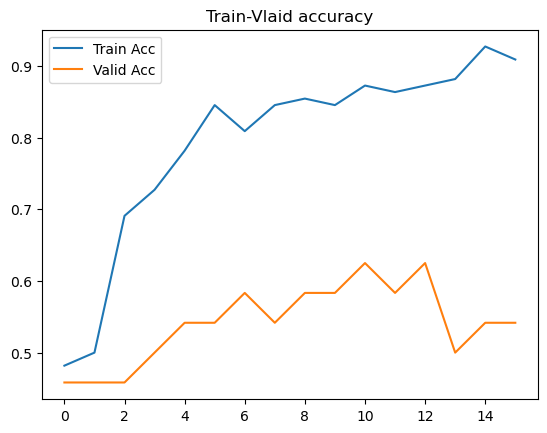

epoch 16 loss: 0.2145: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


train accuracy = 0.90000
[[49  6]
 [ 5 50]]


epoch 16 loss: 0.8251: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


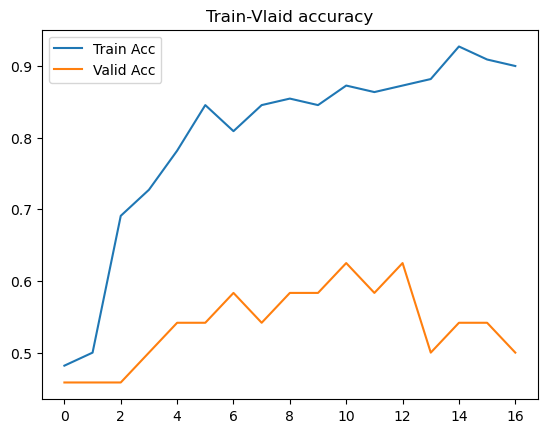

epoch 17 loss: 0.2679: 100%|██████████| 11/11 [00:04<00:00,  2.20it/s]


train accuracy = 0.92727
[[52  3]
 [ 5 50]]


epoch 17 loss: 0.8314: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


validation accuracy = 0.50000
[[6 8]
 [4 6]]


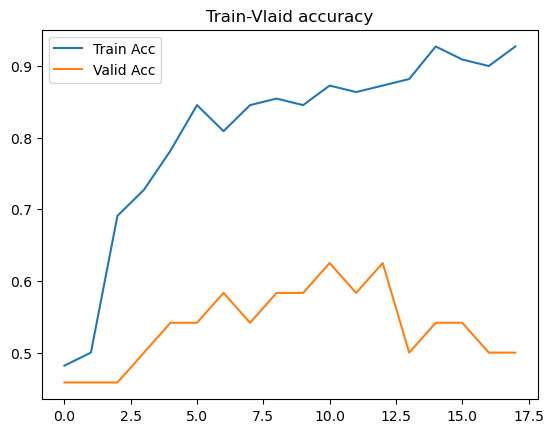

epoch 18 loss: 0.2149: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


train accuracy = 0.93636
[[50  5]
 [ 2 53]]


epoch 18 loss: 0.8464: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


validation accuracy = 0.45833
[[6 8]
 [5 5]]


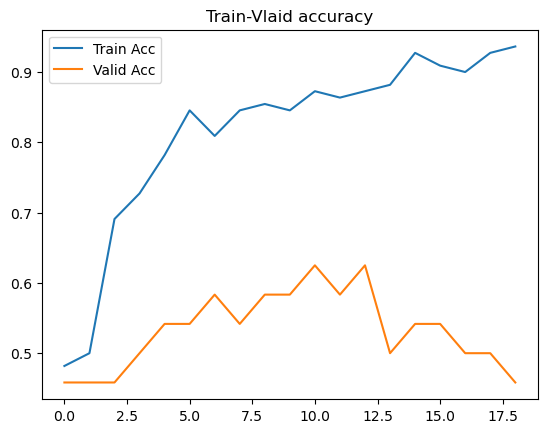

epoch 19 loss: 0.2856: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


train accuracy = 0.95455
[[52  3]
 [ 2 53]]


epoch 19 loss: 0.8874: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


validation accuracy = 0.45833
[[6 8]
 [5 5]]


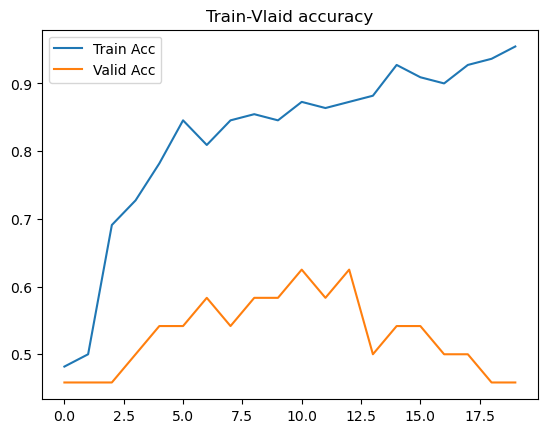

epoch 20 loss: 0.3538: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


train accuracy = 0.89091
[[48  7]
 [ 5 50]]


epoch 20 loss: 0.9153: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


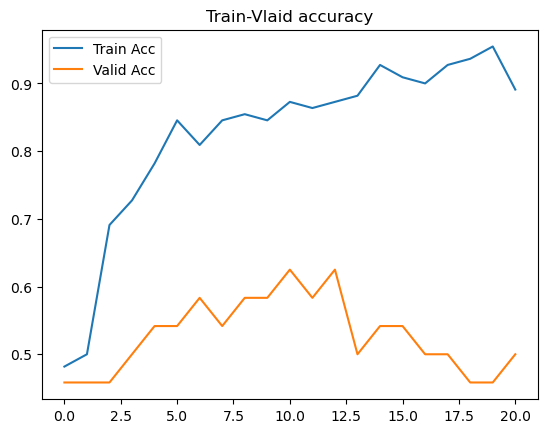

epoch 21 loss: 0.1699: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


train accuracy = 0.96364
[[54  1]
 [ 3 52]]


epoch 21 loss: 0.9051: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


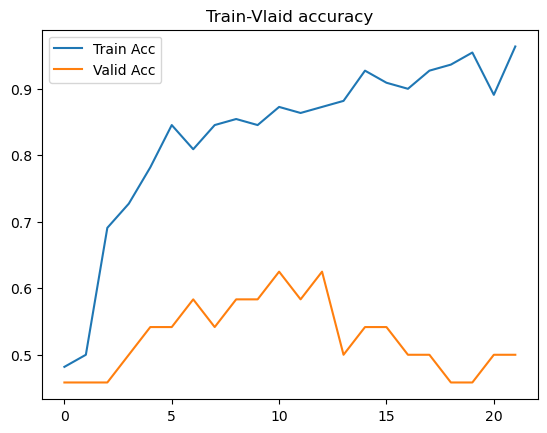

epoch 22 loss: 0.1372: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


train accuracy = 0.92727
[[50  5]
 [ 3 52]]


epoch 22 loss: 0.9120: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


validation accuracy = 0.54167
[[7 7]
 [4 6]]


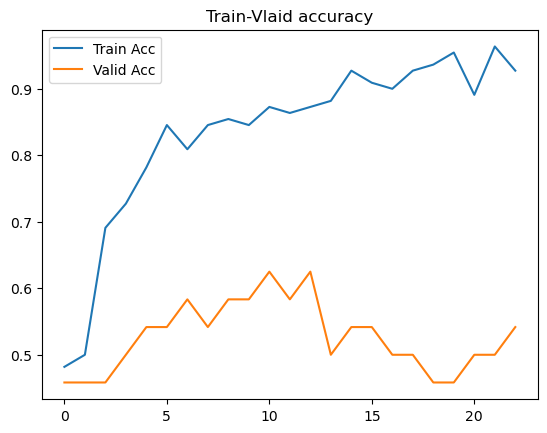

epoch 23 loss: 0.0848: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


train accuracy = 0.93636
[[51  4]
 [ 3 52]]


epoch 23 loss: 0.9607: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


validation accuracy = 0.45833
[[6 8]
 [5 5]]


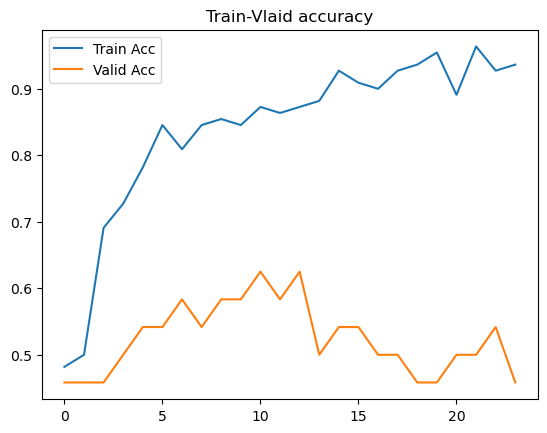

epoch 24 loss: 0.1678: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


train accuracy = 0.91818
[[51  4]
 [ 5 50]]


epoch 24 loss: 0.9551: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


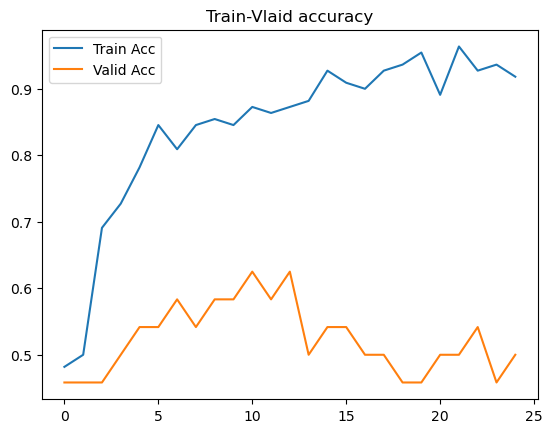

epoch 25 loss: 0.1187: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


train accuracy = 0.99091
[[55  0]
 [ 1 54]]


epoch 25 loss: 0.9571: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


validation accuracy = 0.54167
[[7 7]
 [4 6]]


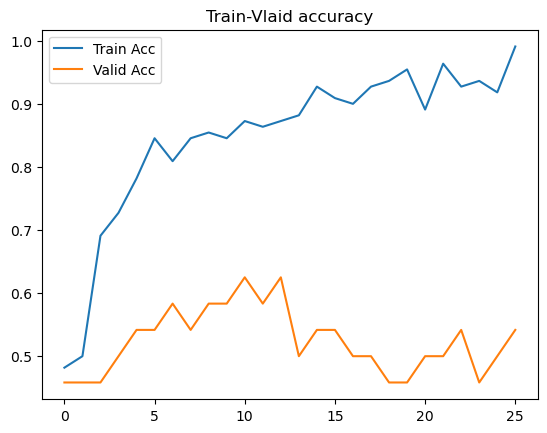

epoch 26 loss: 0.1412: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


train accuracy = 0.91818
[[50  5]
 [ 4 51]]


epoch 26 loss: 0.9529: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


validation accuracy = 0.62500
[[8 6]
 [3 7]]


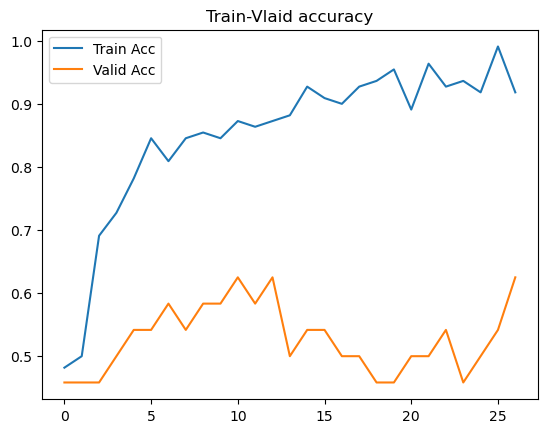

epoch 27 loss: 0.1118: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


train accuracy = 0.99091
[[54  1]
 [ 0 55]]


epoch 27 loss: 0.9766: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


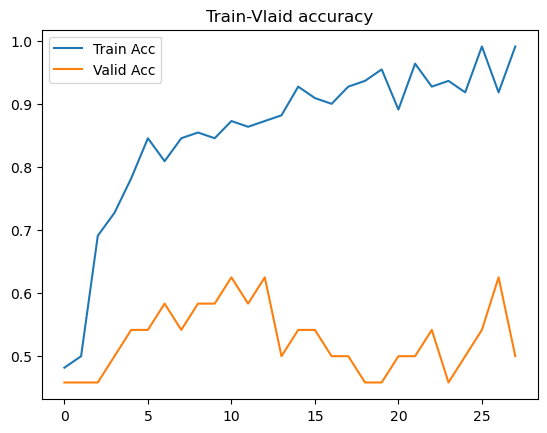

epoch 28 loss: 0.1369: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


train accuracy = 1.00000
[[55  0]
 [ 0 55]]


epoch 28 loss: 0.9658: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


validation accuracy = 0.54167
[[8 6]
 [5 5]]


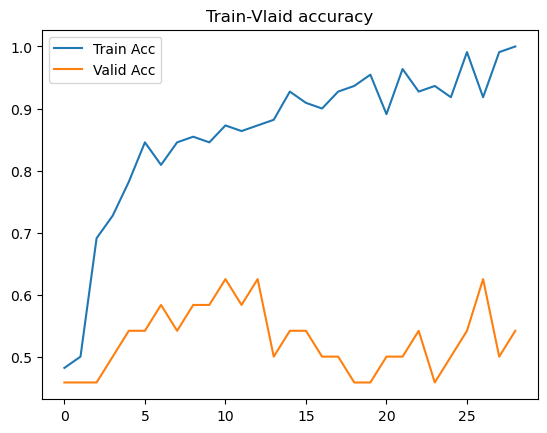

epoch 29 loss: 0.0791: 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]


train accuracy = 0.97273
[[55  0]
 [ 3 52]]


epoch 29 loss: 1.0029: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


validation accuracy = 0.54167
[[8 6]
 [5 5]]


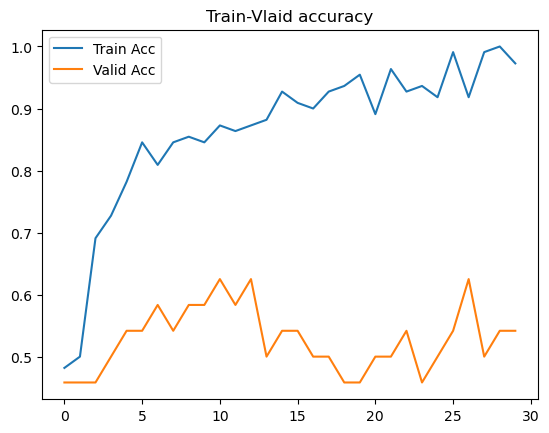

epoch 30 loss: 0.1102: 100%|██████████| 11/11 [00:04<00:00,  2.37it/s]


train accuracy = 0.97273
[[53  2]
 [ 1 54]]


epoch 30 loss: 1.0509: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


validation accuracy = 0.50000
[[6 8]
 [4 6]]


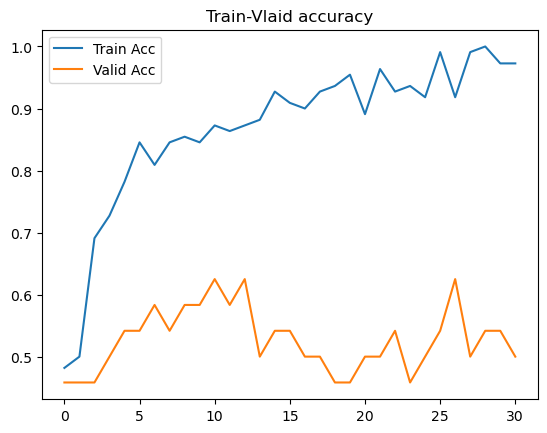

epoch 31 loss: 0.2029: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


train accuracy = 0.93636
[[51  4]
 [ 3 52]]


epoch 31 loss: 1.0648: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


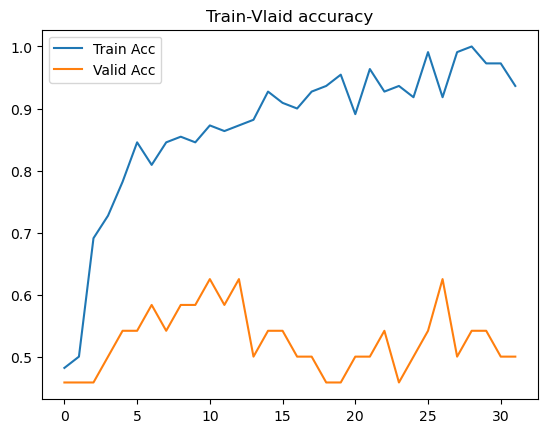

epoch 32 loss: 0.0765: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


train accuracy = 0.96364
[[52  3]
 [ 1 54]]


epoch 32 loss: 1.0534: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


validation accuracy = 0.54167
[[8 6]
 [5 5]]


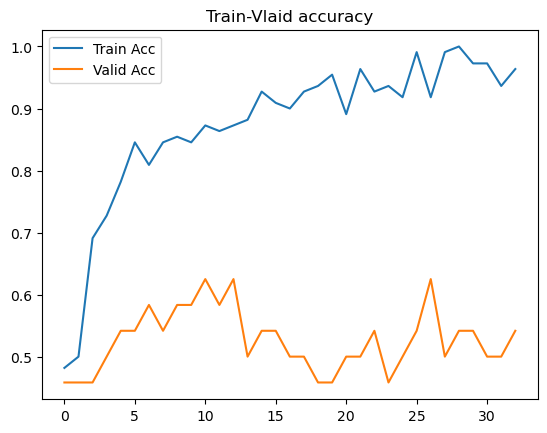

epoch 33 loss: 0.1439: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


train accuracy = 0.98182
[[55  0]
 [ 2 53]]


epoch 33 loss: 1.0308: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


validation accuracy = 0.54167
[[8 6]
 [5 5]]


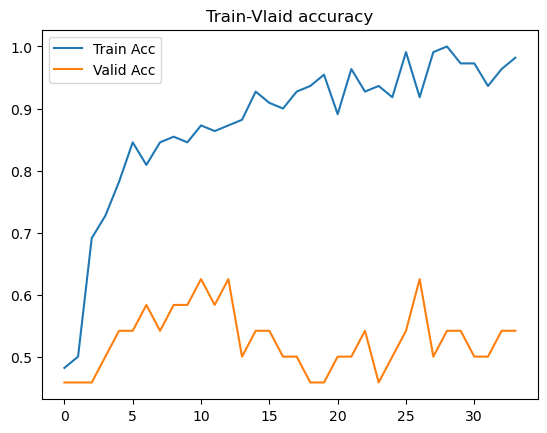

epoch 34 loss: 0.0959: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


train accuracy = 0.97273
[[53  2]
 [ 1 54]]


epoch 34 loss: 1.0743: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


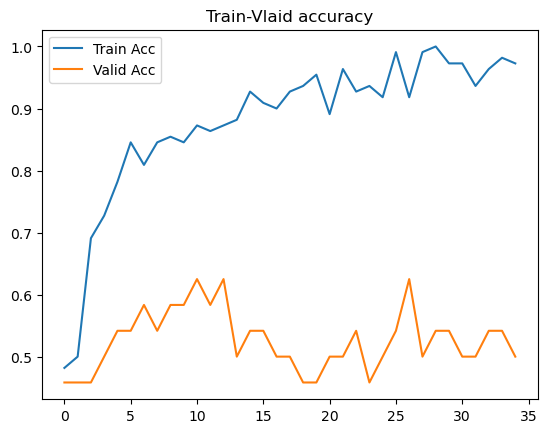

epoch 35 loss: 0.0675: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


train accuracy = 0.98182
[[54  1]
 [ 1 54]]


epoch 35 loss: 1.0339: 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


validation accuracy = 0.54167
[[7 7]
 [4 6]]


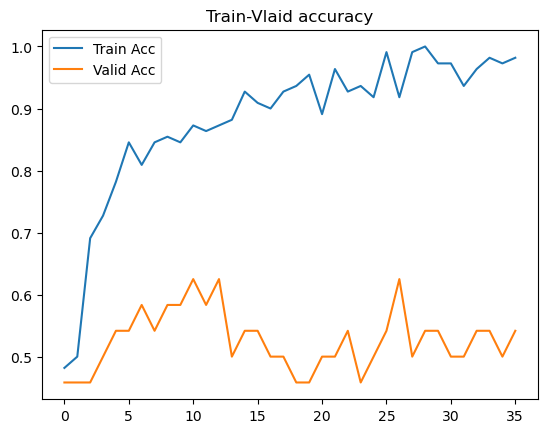

epoch 36 loss: 0.1189: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


train accuracy = 0.98182
[[53  2]
 [ 0 55]]


epoch 36 loss: 1.0542: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


validation accuracy = 0.54167
[[6 8]
 [3 7]]


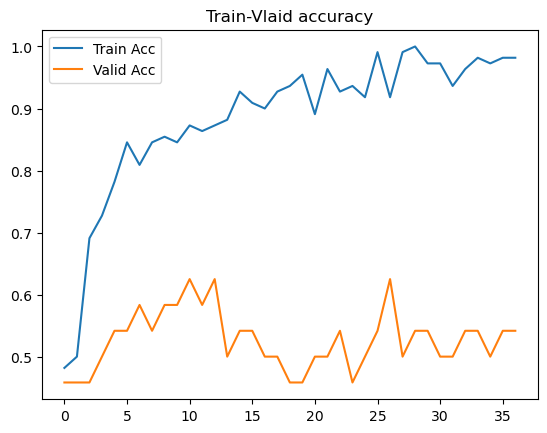

epoch 37 loss: 0.0789: 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]


train accuracy = 0.96364
[[54  1]
 [ 3 52]]


epoch 37 loss: 1.0949: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


validation accuracy = 0.54167
[[6 8]
 [3 7]]


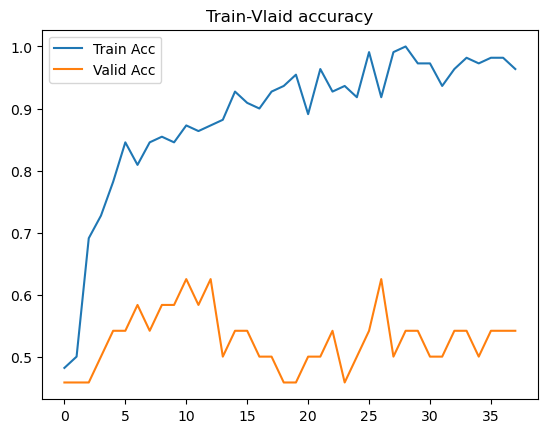

epoch 38 loss: 0.0514: 100%|██████████| 11/11 [00:04<00:00,  2.20it/s]


train accuracy = 0.99091
[[54  1]
 [ 0 55]]


epoch 38 loss: 1.0409: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


validation accuracy = 0.50000
[[6 8]
 [4 6]]


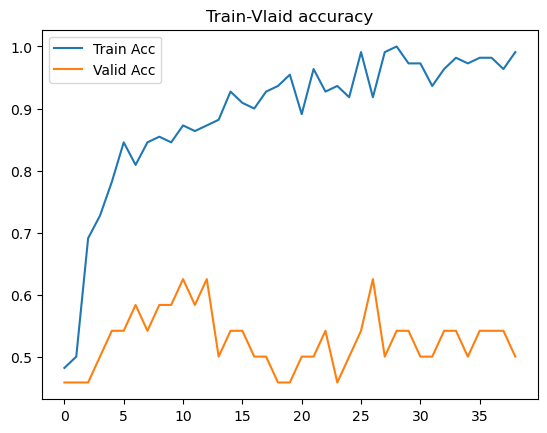

epoch 39 loss: 0.0351: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]


train accuracy = 0.99091
[[55  0]
 [ 1 54]]


epoch 39 loss: 1.0727: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


validation accuracy = 0.50000
[[6 8]
 [4 6]]


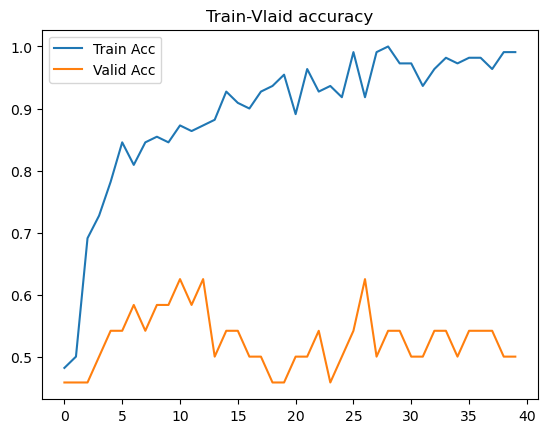

epoch 40 loss: 0.2360: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


train accuracy = 0.96364
[[53  2]
 [ 2 53]]


epoch 40 loss: 1.0773: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


validation accuracy = 0.50000
[[6 8]
 [4 6]]


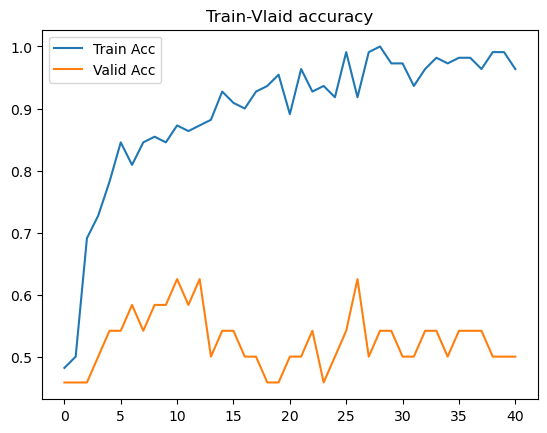

epoch 41 loss: 0.0953: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


train accuracy = 0.99091
[[54  1]
 [ 0 55]]


epoch 41 loss: 1.0651: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


validation accuracy = 0.50000
[[6 8]
 [4 6]]


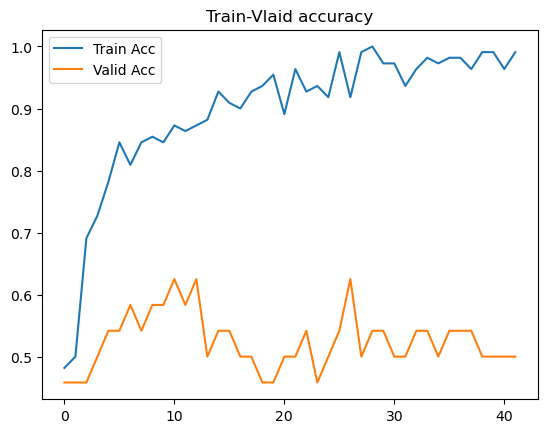

epoch 42 loss: 0.0541: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]


train accuracy = 0.99091
[[55  0]
 [ 1 54]]


epoch 42 loss: 1.0576: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


validation accuracy = 0.54167
[[6 8]
 [3 7]]


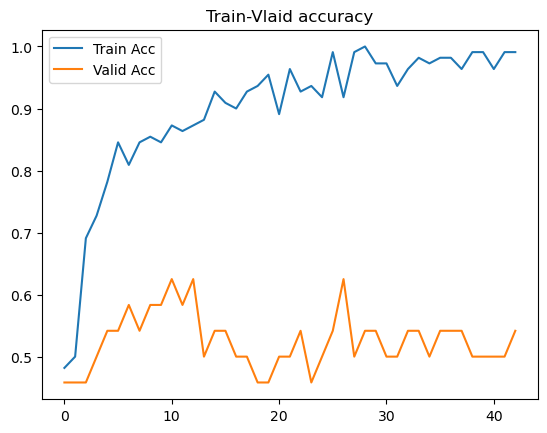

epoch 43 loss: 0.1216: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


train accuracy = 0.97273
[[53  2]
 [ 1 54]]


epoch 43 loss: 1.1237: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


validation accuracy = 0.54167
[[7 7]
 [4 6]]


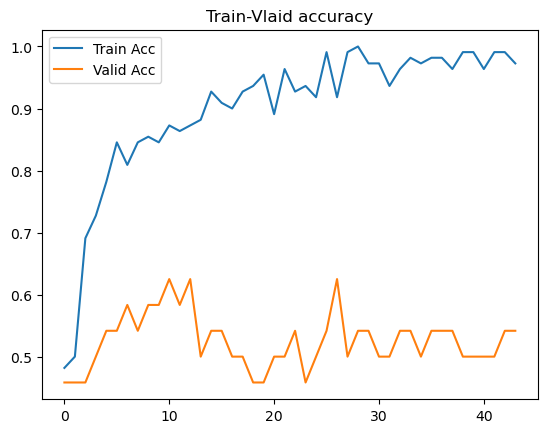

epoch 44 loss: 0.0775: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


train accuracy = 1.00000
[[55  0]
 [ 0 55]]


epoch 44 loss: 1.1081: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


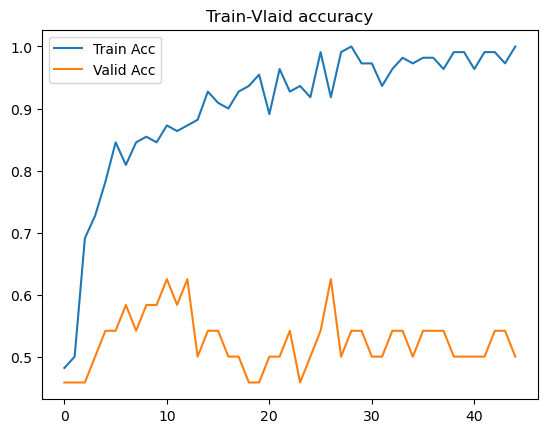

epoch 45 loss: 0.0197: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


train accuracy = 0.98182
[[55  0]
 [ 2 53]]


epoch 45 loss: 1.0667: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


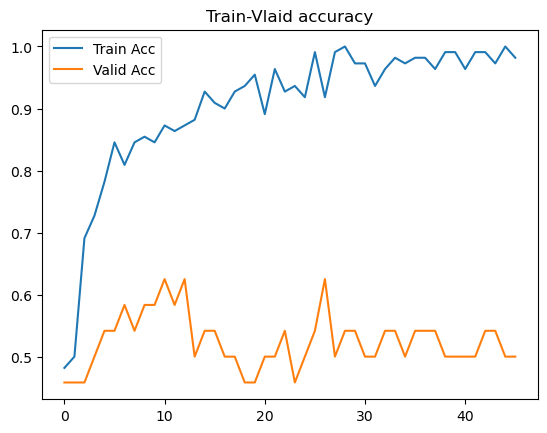

epoch 46 loss: 0.1240: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


train accuracy = 0.99091
[[55  0]
 [ 1 54]]


epoch 46 loss: 1.1304: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


validation accuracy = 0.50000
[[7 7]
 [5 5]]


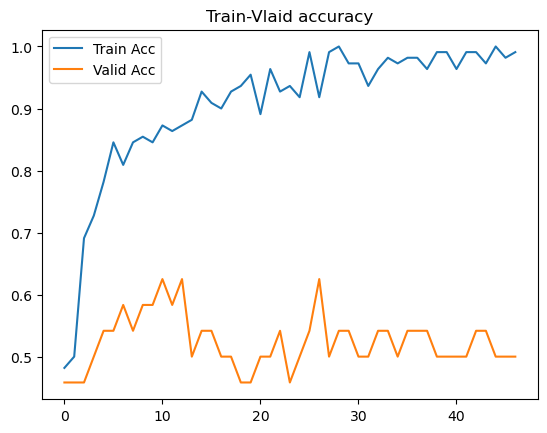

epoch 47 loss: 0.0443: 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]


train accuracy = 0.98182
[[54  1]
 [ 1 54]]


epoch 47 loss: 1.1148: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


validation accuracy = 0.50000
[[6 8]
 [4 6]]


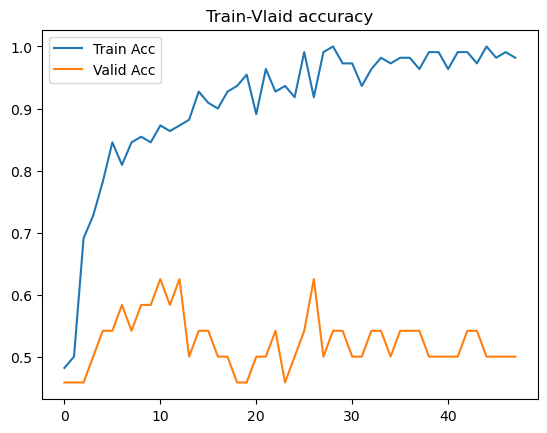

epoch 48 loss: 0.0253: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


train accuracy = 0.96364
[[52  3]
 [ 1 54]]


epoch 48 loss: 1.1900: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


validation accuracy = 0.50000
[[6 8]
 [4 6]]


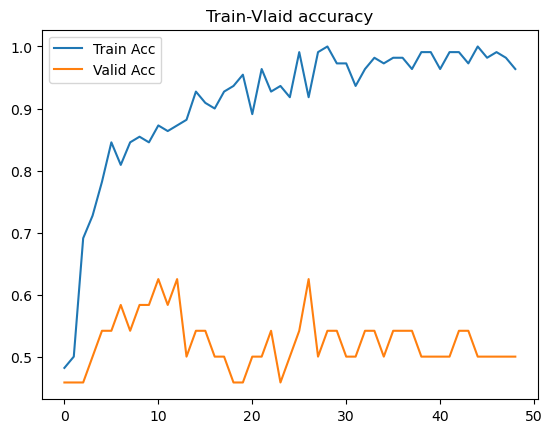

epoch 49 loss: 0.0391: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


train accuracy = 0.98182
[[54  1]
 [ 1 54]]


epoch 49 loss: 1.1782: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


validation accuracy = 0.45833
[[6 8]
 [5 5]]


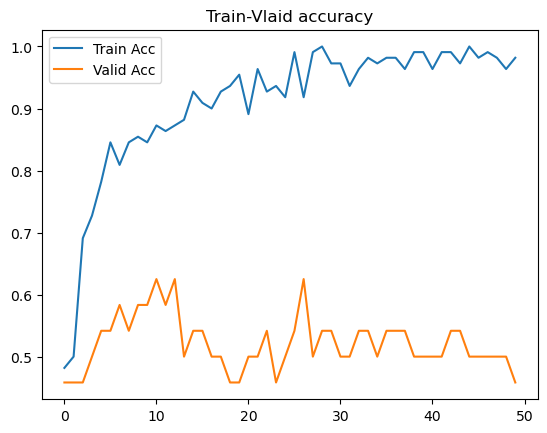

time : 0:05:05
Best Epoch : 10/ 50
Best Train Accuracy : 0.87273
[[47  8]
 [ 6 49]]
Best Valid Accuracy : 0.62500
[[9 5]
 [4 6]]


In [32]:
%run classification_train_efficientnet.ipynb

In [ ]:
#for train, val separately

In [2]:
#cecum = 1, else = 0

true_path = '/Data/data/data_gsun/Cecum/experiment/train/cecum/'
false_path = '/Data/data/data_gsun/Cecum/experiment/train/non_cecum/'

In [3]:
true_dir = [true_path + x for x in os.listdir(true_path) if '.txt' not in x]
false_dir = [false_path + x for x in os.listdir(false_path) if '.txt' not in x]

In [4]:
random.shuffle(true_dir)
random.shuffle(false_dir)

In [5]:
print(len(true_dir))

1274


In [6]:
true_label = [1]*int(len(true_dir))

In [7]:
print(true_label[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [8]:
print(len(true_label))

1274


In [9]:
print(len(false_dir))

15000


In [10]:
false_label = [0]*int(len(false_dir))

In [11]:
print(false_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
print(len(false_label))

15000


In [13]:
whole_dir = true_dir + false_dir

In [14]:
whole_label = true_label + false_label

In [15]:
print(len(whole_dir))

16274


In [16]:
print(len(whole_label))

16274


In [17]:
trn_df = pd.DataFrame(whole_dir, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = whole_label
train = trn_df
train

,image_id,dir,label
0,V0480_0024.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
1,V0376_0079.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
2,V0670_0048.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
3,V0307_0073.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
4,V0612_0022.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
...,...,...,...
16269,V1743_2021_0293_000738.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16270,V1485_2021_0035_001495.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16271,V1880_2021_0430_003530.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16272,V1732_2021_0282_003544.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0


In [18]:
train.label.value_counts()

0    15000
1     1274
Name: label, dtype: int64

In [19]:
#cecum = 1, else = 0

true_val_path = '/Data/data/data_gsun/Cecum/experiment/val/cecum/'
false_val_path = '/Data/data/data_gsun/Cecum/experiment/val/non_cecum/'

In [20]:
true_val_dir = [true_val_path + x for x in os.listdir(true_val_path) if '.txt' not in x]
false_val_dir = [false_val_path + x for x in os.listdir(false_val_path) if '.txt' not in x]

In [21]:
random.shuffle(true_val_dir)
random.shuffle(false_val_dir)

In [22]:
print(len(true_val_dir))

71


In [23]:
true_val_label = [1]*int(len(true_val_dir))

In [24]:
print(true_val_label[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [25]:
print(len(true_val_label))

71


In [26]:
print(len(false_val_dir))

639


In [27]:
false_val_label = [0]*int(len(false_val_dir))

In [28]:
print(false_val_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
print(len(false_val_label))

639


In [30]:
whole_val_dir = true_val_dir + false_val_dir

In [31]:
whole_val_label = true_val_label + false_val_label

In [32]:
print(len(whole_val_dir))

710


In [33]:
print(len(whole_val_label))

710


In [34]:
val_df = pd.DataFrame(whole_val_dir, columns=['image_id'])
val_df['dir'] = val_df['image_id'].apply(lambda x: os.path.dirname(x))
val_df['image_id'] = val_df['image_id'].apply(lambda x: os.path.basename(x))
val_df['label'] = whole_val_label
val = val_df
val

,image_id,dir,label
0,V1824_2021_0374_000004.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
1,V1533_2021_0083_000723.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
2,V1533_2021_0083_000742.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
3,V1434_2020_1204_000377.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
4,V1533_2021_0083_000750.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
...,...,...,...
705,V1434_2020_1204_001067.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
706,V0042_2019_0042_002852.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
707,V1373_2020_1143_002984.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
708,V0042_2019_0042_003166.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0


In [35]:
val.label.value_counts()

0    639
1     71
Name: label, dtype: int64

In [36]:
project_name = 'cecum_classification'
user = 'honbul'
run_name = 'cecum_classification_efficientnet_lite0_size192'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


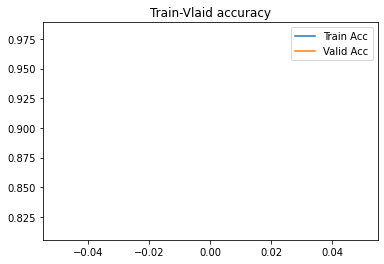

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


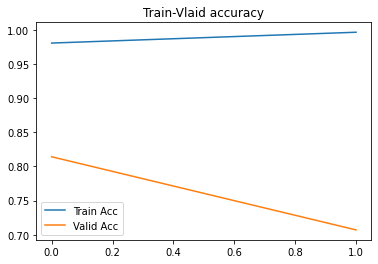

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


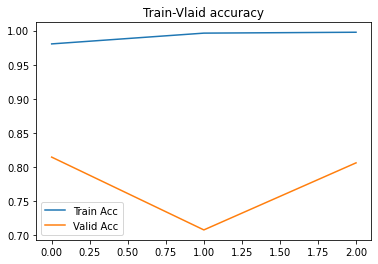

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


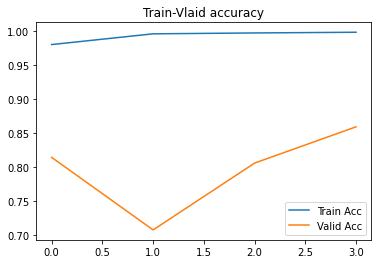

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


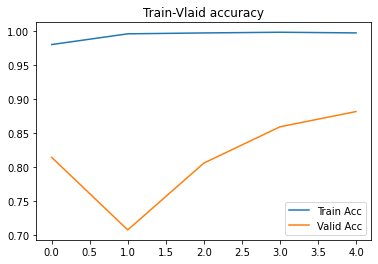

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb